In [9]:
# # Cabeçalho

# Thiago Pacheco Carneiro - 2021
# A partir de código de Matheus Klatt:
# https://colab.research.google.com/drive/1ryPL6nAk8OlDw9F5QaYu3GQOqeMEcuZk?usp=sharing#scrollTo=iregsHCQ0hrx

import numpy as np
import torch
import matplotlib.pyplot as plt
 
# # Modelos

class Modelo():
    def __init__(self, Nx = 300, Nz = 300) -> None:
        self.Nx=Nx#300
        self.Nz=Nz#300
        self.vp=torch.tensor(np.zeros((self.Nz, self.Nx)), requires_grad=False).cuda()
        self.Na=0
        self.Ntopo=0
        self.fat = 0
        self.fat_c = torch.tensor(np.ones((self.Nz, self.Nx)), requires_grad=False).cuda()
        self.zbv = False
        self.profundidade_zbv = 0
        self.vtopo = 0
    
    def copy(self):
        return ModeloCopiado(self)

    def cria_bordas_cerjan(self,Na = 50,fat=0.0025):
        self.Na += Na
        self.fat = fat
        Nzz = self.Nz + Na
        Nxx = self.Nx + 2*Na
        ext_vp=torch.tensor(np.zeros((Nzz,Nxx)), requires_grad=False).cuda()
        ext_vp[:-Na,Na:-Na]=self.vp
        for i in range(Na+1):
            ext_vp[-i-1,:]=ext_vp[-Na-1,:]
            ext_vp[:,i]=ext_vp[:,Na+1]
            ext_vp[:,-i-1]=ext_vp[:,-Na-1]
        self.vp=ext_vp
        self.Nz=Nzz
        self.Nx=Nxx
        self.fat_c = torch.tensor(np.ones((Nzz,Nxx)), requires_grad=False).cuda()
        if Na != 0:
            for i in range(Nzz - Na, Nzz):
                self.fat_c[i, :] = np.exp(-((fat * (Nzz - Na - i)) ** 2))
            for k in range(Na):
                self.fat_c[:, k] = np.exp(-((fat * (Na - k)) ** 2)) * self.fat_c[:, Na]
            for k in range(Nxx - Na+1, Nxx):
                self.fat_c[:, k] = np.exp(-(((fat + 0.5*fat) * (Nxx - Na - k)) ** 2))  * self.fat_c[:, Nxx-Na]
        return self

    def cria_borda_topo(self, Ntopo: int):
        self.Ntopo = Ntopo
        Nzz = self.Nz + self.Ntopo
        ext_vp=torch.tensor(np.zeros((Nzz, self.Nx)), requires_grad=False).cuda()
        ext_vp[self.Ntopo:,:]=self.vp
        for i in range(self.Ntopo):
            ext_vp[i,:]=self.vp[0,:]
        self.vp = ext_vp
        self.Nz = Nzz
        return self

    def cria_ZBV(self, profundidade = 7, velocidade = 450):
        self.vp[:profundidade,:]=velocidade
        self.zbv = True
        self.profundidade_zbv=profundidade
        return self

class ModeloCopiado(Modelo):
    def __init__(self, original) -> None:
        super().__init__(original.Nx, original.Nz)
        self.Na = original.Na
        self.vp = original.vp.clone().cuda()
        self.Ntopo = original.Ntopo
        self.fat = original.fat
        self.fat_c = original.fat_c.clone().cuda()
        self.zbv = original.zbv
        self.profundidade_zbv = original.profundidade_zbv
        self.vtopo = original.vtopo

class ModeloHomogeneo(Modelo):
    def __init__(self, Nx=300, Nz=300, v=1500) -> None:
        super().__init__(Nx=Nx, Nz=Nz)
        self.vp[:,:]=v
        self.vtopo=v

class ModeloParalelas(Modelo):
    def __init__(self, Nx = 300, Nz = 300, v = [1500, 3000, 5000]) -> None:
        super().__init__(Nx,Nz)
        self.vp[:int(self.Nz/3),:]=v[0]#1500
        self.vp[int(self.Nz/3):int(2*self.Nz/3),:]=v[1]#3000
        self.vp[int(2*self.Nz/3):,:]=v[2]#5000
        self.vtopo=v[0]

class ModeloParalelasRandomizado(Modelo):
    def __init__(self, Nx = 300, Nz = 300, zv = ((100,1500), (200,3000), (300,5000))) -> None:
        super().__init__(Nx,Nz)
        início=0
        for fim, velocidade in zv:
            delta_início = 0
            for x in range(self.vp.shape[1]):
                if início != 0:
                    delta_início += np.random.choice([-1,1]+[0]*3)
                self.vp[início + delta_início:,:] = velocidade
            início=fim
        self.vtopo=zv[0][1]

class ModeloRandomizado(Modelo):
    def __init__(self, Nx=300, Nz=300, n_camadas=15) -> None:
        super().__init__(Nx=Nx, Nz=Nz)
        self.vp[:,:]=1500
        for i in range(n_camadas):
            #d = np.random.randint(-Nz//n_camadas,Nz//n_camadas)
            d = np.random.randint(50,100)
            a = np.random.randint(0,Nz//n_camadas)
            k = np.pi/np.random.randint(50,Nx)
            fase = np.random.random()*np.pi*2
            velocidade = np.random.randint(1500,1500+2000*(1+n_camadas-i)//n_camadas)
            #print(velocidade)
            for x in range(Nx):
                profundidade = int(Nz-i*(Nz//n_camadas)+a*np.sin(k*x+fase))
                self.vp[:profundidade+d,x] = velocidade
        self.vtopo=velocidade

class FonteSismica():
    def __init__(self,fcorte = 30, Nt0 = 0, dt = 0.0006, x = 150, z = 5, intensidade = 1.) -> None:
        self.fcorte = fcorte #30     # frequência de corte (Hz)
        self.Nt0 = Nt0
        self.dt = dt #0.0006
        self.x = x
        self.z = z

        self.Nf = int(4 * np.sqrt(np.pi) / (self.fcorte * self.dt)) # Passos de tempo ao longo dos quais a fonte é injetada (tm discretizado)

        self.pulso = np.zeros(self.Nf) # Inicialização do vetor que guarda o as amplitudes do pulso Ricker que é usado como fonte
        self.t = np.zeros(self.Nf) # Inicialização do vetor (td) que guarda os instantes de tempo em segundos nos quais a fonte é aplicada

        self.TF = 2 * np.sqrt(np.pi) / self.fcorte       # Período da função Gaussiana (t0)
        self.fc = self.fcorte / (3. * np.sqrt(np.pi))    # Frequência central

        # Laço que cria o pulso Ricker para cada instante (td) de aplicação da fonte
        for n in range(self.Nf):
            self.t[n] = n*self.dt - self.TF + self.Nt0*self.dt
            self.pulso[n] = intensidade*(-np.exp(-np.pi * (np.pi * self.fc * self.t[n]) ** 2) * (1 - 2 * np.pi * (np.pi * self.fc * self.t[n]) * (np.pi * self.fc * self.t[n])))

class FonteRuidosa(FonteSismica):
    def __init__(self, fcorte=30, Nt0=0, dt=0.0006, x=150, z=5, intensidade=1) -> None:
        fcorte=np.random.randint(fcorte//2,fcorte+fcorte//2)
        intensidade=(np.random.random()*0.1+1)*intensidade
        x=x+np.random.randint(-5,5)
        z=z+np.random.randint(-1,1)
        super().__init__(fcorte=fcorte, Nt0=Nt0, dt=dt, x=x, z=z, intensidade=intensidade)
        for i in range(len(self.pulso)):
            self.pulso[i]=(np.random.random()*0.25+1)*self.pulso[i]

class Malha():
    def __init__(self, modelo, fonte=FonteSismica(), cerjan = False, reynolds = False, suprime_ruido = False, z_receptor=5, Na=50) -> None:
        self.mod = modelo.copy()
        self.fontes = [fonte]
        self.cerjan=cerjan
        self.reynolds=reynolds
        self.suprime_ruido = suprime_ruido

        if self.suprime_ruido:
            self.mod.cria_borda_topo(self.mod.Nz)
            
        if self.cerjan:
            self.mod.cria_bordas_cerjan(Na=Na)
        
        self.dt = 0.0006

        self.h = 10

        self.A = self.mod.vp * (self.dt/self.h)
        self.C = (- (self.A**2)/12)
        
        self.z_receptor = z_receptor+self.mod.Ntopo
        self.ntotal = 10000

        self.P1 = torch.tensor(np.zeros((self.mod.Nz, self.mod.Nx)), requires_grad=False).cuda()               # Matriz no tempo passado
        self.P2 = torch.tensor(np.zeros((self.mod.Nz, self.mod.Nx)), requires_grad=False).cuda()               # Matriz no tempo presente
        self.P3 = torch.tensor(np.zeros((self.mod.Nz, self.mod.Nx)), requires_grad=False).cuda()               # Matriz no tempo futuro
        self.sis = (np.zeros((self.ntotal, self.mod.Nx-(2*self.mod.Na))))          # Matriz do sismograma

        self.nsnaps = 20
        self.snaps_t = np.linspace(0,self.ntotal-1,self.nsnaps,dtype=np.int32)
        self.P_snaps=np.zeros((self.nsnaps,self.mod.Nz,self.mod.Nx))

    def insere_fonte(self, Nt0 = 0, x = 150, z=5, intensidade = 1):
        self.fontes.append(FonteSismica(Nt0 = Nt0, dt = self.dt, x = x, z = z, intensidade = intensidade))
    
    #@njit(parallel=True)
    def executa_mdf(C,P1,P2,P3):
        P3[2:-2, 2:-2] = \
            C[2:-2,2:-2] * ( \
                P2[2:-2, 4:] + P2[2:-2, :-4] + P2[4:, 2:-2] + P2[:-4, 2:-2] \
                - 16 * (P2[2:-2, 3:-1] + P2[2:-2, 1:-3] + P2[3:-1, 2:-2] + P2[1:-3, 2:-2]) \
                + 60 * (P2[2:-2, 2:-2]) \
            ) + 2 * (P2[2:-2, 2:-2]) - P1[2:-2, 2:-2]
    
    #@njit(parallel=True)
    def calcula_reynolds(A,P2,P3):
        P3[:2,2:-2] = P2[:2,2:-2] + A[:2,2:-2] * (P2[1:3, 2:-2] - P2[:2,2:-2])
        P3[-2:,2:-2] = P2[-2:,2:-2] - A[-2:,2:-2] * (P2[-2:, 2:-2] - P2[-3:-1,2:-2])
        P3[2:-2,:2] = P2[2:-2,:2] + A[2:-2,:2] * (P2[2:-2, 1:3] - P2[2:-2,:2])
        P3[2:-2,-2:] = P2[2:-2,-2:] - A[2:-2,-2:] * (P2[2:-2, -2:] - P2[2:-2,-3:-1])
    
    #@njit(parallel=True)
    def calcula_cerjan(P2,P3,fat_c):
        P2 *= fat_c
        P3 *= fat_c        
                
    def modelagem(self, z_receptor=False):
        if z_receptor:
            self.z_receptor = z_receptor + self.mod.Ntopo
        c_snap=0
        for n in range(self.ntotal):
            for fnt in self.fontes:
                if fnt.Nt0 <= n < fnt.Nt0+fnt.Nf:
                    z = fnt.z + self.mod.Ntopo
                    x = fnt.x + self.mod.Na
                    v = self.A[z, x]
                    self.P2[z, x] += fnt.pulso[n-fnt.Nt0] * v * v
            Malha.executa_mdf(self.C, self.P1, self.P2, self.P3)
            if self.reynolds:
                Malha.calcula_reynolds(self.A, self.P2, self.P3)
            if self.cerjan:
                Malha.calcula_cerjan(self.P2, self.P3, self.mod.fat_c)
            self.P1 = self.P2
            self.P2 = self.P3
            self.P3 = self.P3.clone()
            self.sis[n,:] = (self.P3[self.z_receptor,self.mod.Na:self.mod.Nx-self.mod.Na]).cpu().detach().numpy()
            if(n == self.snaps_t[c_snap]):
                self.P_snaps[c_snap] = self.P3.cpu().detach().numpy()
                c_snap+=1
        return self


    def sismógrafos(self, remover_onda_direta=False):
        if (remover_onda_direta):
            modelo_h=ModeloHomogeneo(self.mod.Nx - (2 * self.mod.Na), self.mod.Nz - self.mod.Na - self.mod.Ntopo, self.mod.vtopo)
            if self.mod.profundidade_zbv > 0:
                modelo_h.cria_ZBV(profundidade=self.mod.profundidade_zbv)
            if self.mod.Ntopo > 0:
                modelo_h.cria_borda_topo(self.mod.Nx)
            sis_homogeneo=Malha(modelo_h, self.fontes[0], self.cerjan, self.reynolds, z_receptor=self.z_receptor - self.mod.Ntopo).modelagem().sis
            sis_eff=self.sis-sis_homogeneo
        else:
            sis_eff=self.sis
        return sis_eff

def simula_ZBV(modelo=ModeloParalelas(), fonte=FonteSismica(), profundidade = 15, velocidade = 450, plot=True):
    modelo.cria_ZBV(profundidade=profundidade, velocidade=velocidade)
    m = Malha(modelo=modelo, fonte=fonte, cerjan=True, reynolds=True)
    m.modelagem()
    if plot:
        m.plot()
    else:
        return m.sismógrafos(remover_onda_direta=False)

def simula_ZBV_suprimida(modelo=ModeloParalelas(), fonte=FonteSismica(), profundidade = 15, velocidade = 450, plot = True):
    modelo.cria_ZBV(profundidade=profundidade, velocidade=velocidade)
    m = Malha(modelo=modelo, fonte=fonte, cerjan=True, reynolds=True, suprime_ruido=True)
    m.modelagem()
    if plot:
        m.plot(remover_onda_direta=True)
    else:
        return m.sismógrafos(remover_onda_direta=True)

# import time
# lista = []
# start = time.perf_counter()
# for n in range(10):
#     print(".",end="")
#     modelo = modelo_randomizado()
#     profundidade = np.random.randint(7,15)
#     modelo.vp[:profundidade,:]=450
#     fonte = fonte_ruidosa()
#     t1 = modelo.vp.cpu().detach().numpy()
#     t2 = simula_ZBV(modelo=modelo, fonte=fonte, profundidade=profundidade, plot=False)
#     t3 = simula_ZBV_suprimida(modelo=modelo, fonte=fonte, profundidade=profundidade, plot=False)
#     ruído=0.001
#     for t in range(t2.shape[0]):
#         for x in range(t2.shape[1]):
#             t2[t,x]+=-ruído+2*ruído*np.random.random()
#     lista.append((t1,t2,t3))
# lista = np.array(lista,dtype=object)
# end = time.perf_counter()
# print('\n',end - start)

# np.savez_compressed('dados_pytorch',dados=lista)

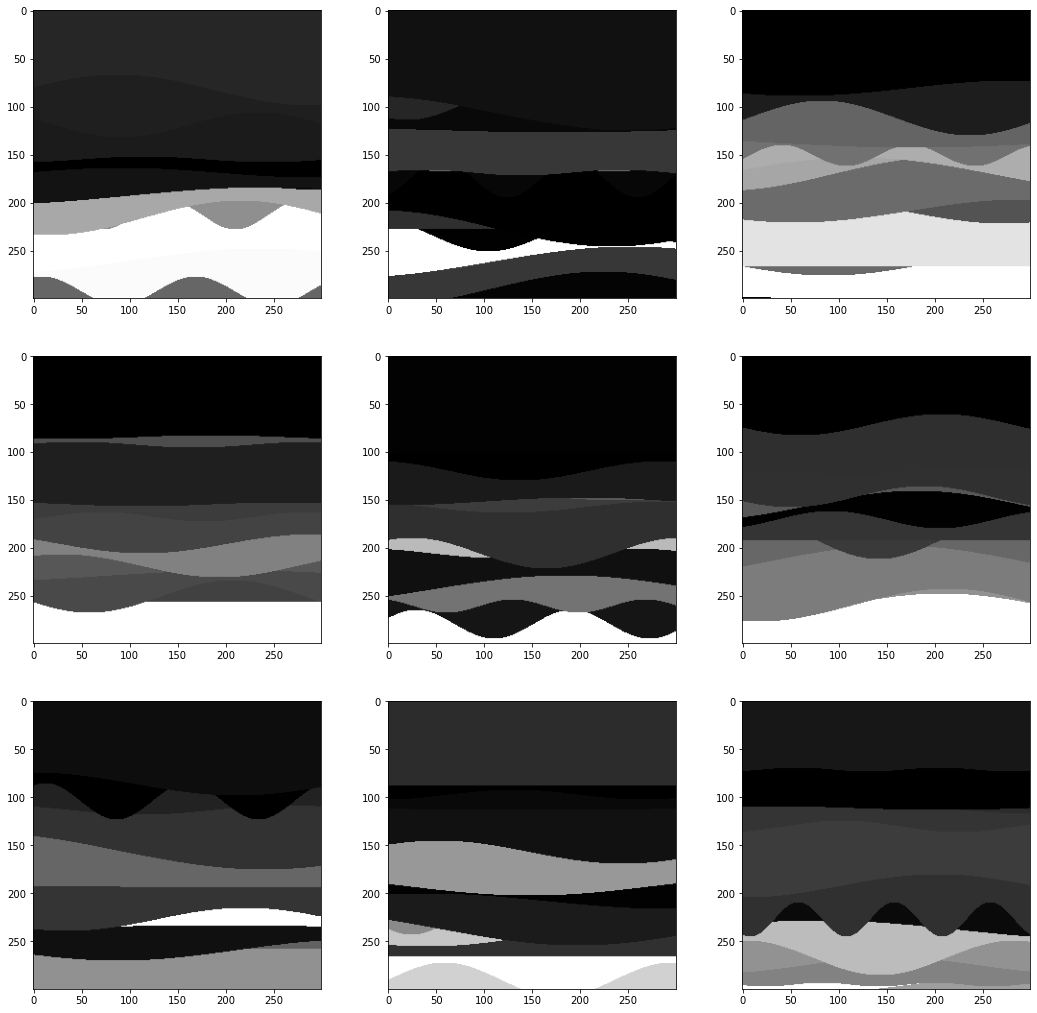

In [15]:
lista = []
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(18,18))
for i in range(9):
    mod = ModeloRandomizado()
    lista.append(mod)
    ax[i//3,i%3].imshow(mod.vp.cpu(), cmap='gray')
plt.show()

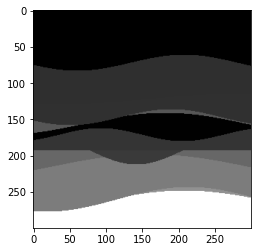

In [19]:
plt.imshow(lista[5].vp.cpu(), cmap='gray')

In [11]:
import time
def gera_CMP(modelo = ModeloRandomizado(), profundidade = None, fonte = None):
    dicionário = dict()
    if profundidade is None:
        profundidade = np.random.randint(7,15)
    modelo.vp[:profundidade,:]=450
    if fonte is None:
        fonte = FonteRuidosa()
    pulso = fonte.pulso
    vp = modelo.vp
    sis_x = modelo.Nx-(2*modelo.Na)
    CMP_X = np.zeros((10000,sis_x))
    CMP_y = np.zeros((10000,sis_x))
    for x in range(sis_x):
        print(x,end='')
        start = time.perf_counter()
        fonte.x = x
        mp = sis_x-x-1
        X_ = simula_ZBV(modelo=modelo, fonte=fonte, profundidade=profundidade, plot=False)
        CMP_X[:,mp]=X_[:,mp]
        y_ = simula_ZBV_suprimida(modelo=modelo, fonte=fonte, profundidade=profundidade, plot=False)
        CMP_y[:,mp]=y_[:,mp]
        end = time.perf_counter()
        print('\t',end - start)
    dicionário = {'modelo':vp.cpu().detach().numpy(),
                  'pulso':pulso,
                  'CMP_X':CMP_X,
                  'CMP_y':CMP_y}
    return dicionário

In [20]:
dicionário = gera_CMP(modelo=lista[5])

0	 21.68340800000078
1	 21.578906099999585
2	 22.215032000000065
3	 21.78971559999991
4	 21.416822499999398
5	 20.499280300000464
6	 20.708666399999856
7	 20.958534399998825
8	 21.529518100000132
9	 20.77688069999931
10	 20.420462599999155
11	 20.45857139999862
12	 20.216350200000306
13	 20.588616199998796
14	 20.40745640000023
15	 20.32109909999963
16	 20.536034400000062
17	 20.4773239999995
18	 20.200229000000036
19	 19.8811525000001
20	 20.062730499999816
21	 20.3801569999996
22	 20.41422799999964
23	 20.395177299998977
24	 20.687858999999662
25	 20.870175500000187
26	 21.00672659999873
27	 20.684809999998834
28	 20.999738700000307
29	 20.34310060000098
30	 20.903700600001685
31	 21.07799420000083
32	 20.59518500000013
33	 21.090074300000197
34	 20.440385500000048
35	 20.679198600000746
36	 20.56144470000072
37	 20.744599699999526
38	 20.64503010000044
39	 20.30476920000001
40	 18.161605600000257
41	 17.65916990000005
42	 17.41514730000017
43	 17.46530359999997
44	 17.49523989999943

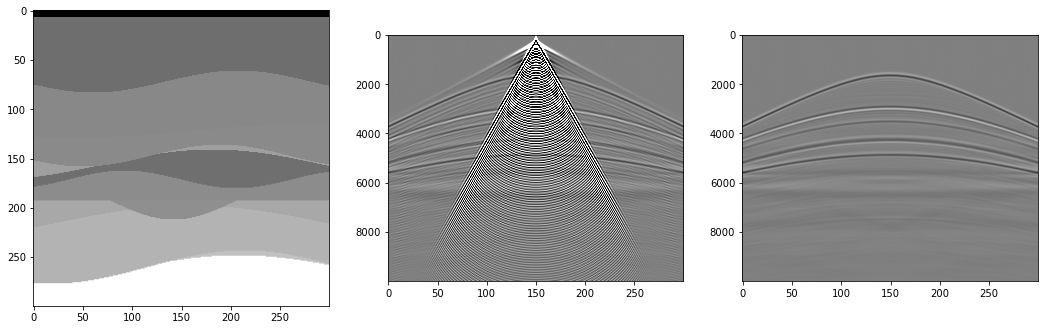

In [21]:
t1, t2, t3 = (dicionário['modelo'], dicionário['CMP_X'], dicionário['CMP_y'])
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(18,6))
im0=ax[0].imshow(t1, cmap='gray')
#fig.colorbar(im0, ax=ax, fraction=0.04, pad=0.08, label='Amplitude', aspect=10)
im1=ax[1].imshow(t2, aspect=1/40, cmap='gray', vmin=-0.001, vmax=0.001)
#fig.colorbar(im1, ax=ax, fraction=0.04, pad=0.08, label='Amplitude', aspect=10)
im2=ax[2].imshow(t3, aspect=1/40, cmap='gray', vmin=-0.001, vmax=0.001)
#fig.colorbar(im2, ax=ax, fraction=0.04, pad=0.08, label='Amplitude', aspect=10)
plt.show()

In [22]:
np.savez_compressed('cmp2',cmp=dicionário)